## Final Project Submission

Please fill out:
* Student name: Andre Layton
* Student pace: Part-time Flex Cohort
* Scheduled project review date/time: September 11th, 2023 at 1pm
* Instructor name: Morgan Jones
* Blog post URL: 


## Overview
Keller Williams Realty has acquired some new property that they are looking to put on the market and sell within the 1-2 years. Houses in their inventory (?) are allotted more time before reselling, but this is their first property in the Pacific Northwest, and would like to use this project to expand their business into that region. This project aims to give Keller Williams an idea on what specific renovations they need to focus on in order to drive the sales price higher and by how much.

## Business Problem
If you are struggling to define a stakeholder, we recommend you complete a project for a real estate agency that helps homeowners buy and/or sell homes. A business problem you could focus on for this stakeholder is the need to provide advice to homeowners about how home renovations might increase the estimated value of their homes, and by what amount.

-**Keller Williams Realty**
Founded in Austin, Texas, in 1983 by Gary Keller and Joe Williams, Keller Williams Realty has grown to be an international real estate brokerage with a focus on technology, similar to many other major brokerages thriving today.

In November, Keller Williams Realty reported agents had closed $381.4 billion in deals in the first three-quarters of 2022. In the same report, the company noted it has more than 177,000 agents in the U.S. and Canada, with another 17,000 in other countries.

With that number of agents, it shouldn’t be a surprise that people in the U.S. should be able to find a Keller Williams agent just about anywhere.

-What renovations will increase the estimated value (price) of the homes?

-By how much?

## Data Understanding
....

In [ ]:
# Your code here - remember to use markdown cells for comments as wseell!

In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import math
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# %load column_names.md
# Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.


In [41]:
housing_data = pd.read_csv('kc_house_data.csv')
housing_df2 = housing_data.drop(['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'address', 'lat', 'long'], 
                               axis=1)
housing_df2.head(10)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,grade,heat_source,sewer_system,sqft_garage,sqft_patio,yr_built
0,7399300360,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,Good,7 Average,Gas,PUBLIC,0,40,1969
1,8910500230,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,Average,7 Average,Oil,PUBLIC,0,240,1950
2,1180000275,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,Average,7 Average,Gas,PUBLIC,0,0,1956
3,1604601802,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,Average,9 Better,Gas,PUBLIC,200,270,2010
4,8562780790,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,Average,7 Average,Electricity,PUBLIC,550,30,2012
5,2807100156,625000.0,2,1.0,1190,5688,1.0,NO,NO,YES,Average,7 Average,Electricity,PUBLIC,300,0,1948
6,5122400111,1317227.0,3,3.0,2080,27574,1.0,NO,NO,NO,Good,9 Better,Oil,PRIVATE,0,150,1951
7,7137850210,820000.0,3,2.5,2214,3506,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,440,206,2019
8,2944500680,780000.0,4,2.5,2340,8125,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,440,70,1989
9,2619950340,975000.0,4,2.5,2980,5859,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,540,170,2011


....Begin talking about previewing information in this dataset...

In [42]:
housing_df2.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_garage,sqft_patio,yr_built
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,330.211142,217.412038,1975.163953
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,285.770536,245.302792,32.067362
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,0.000000,0.000000,1900.000000
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,0.000000,40.000000,1953.000000
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,400.000000,150.000000,1977.000000
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,510.000000,320.000000,2003.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,3580.000000,4370.000000,2022.000000


In [43]:
housing_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30155 non-null  int64  
 1   price         30155 non-null  float64
 2   bedrooms      30155 non-null  int64  
 3   bathrooms     30155 non-null  float64
 4   sqft_living   30155 non-null  int64  
 5   sqft_lot      30155 non-null  int64  
 6   floors        30155 non-null  float64
 7   waterfront    30155 non-null  object 
 8   greenbelt     30155 non-null  object 
 9   nuisance      30155 non-null  object 
 10  condition     30155 non-null  object 
 11  grade         30155 non-null  object 
 12  heat_source   30123 non-null  object 
 13  sewer_system  30141 non-null  object 
 14  sqft_garage   30155 non-null  int64  
 15  sqft_patio    30155 non-null  int64  
 16  yr_built      30155 non-null  int64  
dtypes: float64(3), int64(7), object(7)
memory usage: 3.9+ MB


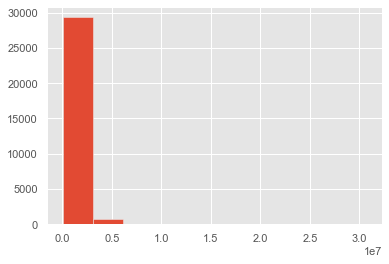

In [44]:
housing_df2['price'].hist();

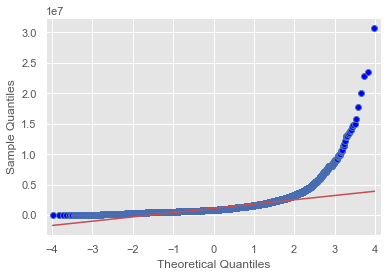

In [45]:
sm.qqplot(housing_df2['price'], line='r');

...plots above show that price data is not normally distributed.. 
shows more right skewness.. decide what to do (i.e drop outliers)

In [46]:
housing_df2['heat_source'].value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

## Data Preparation

In [47]:
# Begin filtering data
housing_df3 = housing_df2[['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'heat_source',
                          'sqft_garage', 'sqft_patio']]

# Filter dataset to houses with certain heating sources (e.g., the top three)
top3_hs = ['Gas', 'Electricity', 'Oil']
housing_df3 = housing_df3[housing_df3['heat_source'].isin(top3_hs)]
housing_df3.tail(10)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,heat_source,sqft_garage,sqft_patio
30145,2423089047,705000.0,3,2.5,2260,50965,2.0,Electricity,480,200
30146,3915500105,380000.0,3,1.0,860,7805,1.0,Gas,0,0
30147,2865600230,665000.0,3,2.5,2100,7210,2.0,Gas,440,40
30148,6142050730,1325000.0,5,3.5,3100,6428,2.0,Gas,710,110
30149,9376300851,719000.0,3,2.5,1270,1141,2.0,Gas,200,60
30150,7834800180,1555000.0,5,2.0,1910,4000,1.5,Oil,0,210
30151,194000695,1313000.0,3,2.0,2020,5800,2.0,Gas,0,520
30152,7960100080,800000.0,3,2.0,1620,3600,1.0,Gas,240,110
30153,2781280080,775000.0,3,2.5,2570,2889,2.0,Gas,480,100
30154,9557800100,500000.0,3,1.5,1200,11058,1.0,Oil,420,0


In [62]:
# Dummying the 'heat_source' column
housing_df4 = pd.get_dummies(housing_df3, prefix=['Heat Source'], prefix_sep=': ', columns = ['heat_source'])

# Rename features
housing_df4.rename(columns= {'id':'House ID Number', 'price':'Sales Price', 'bedrooms':'No. of Bedrooms', 
                             'bathrooms':'No. of Bathrooms', 'sqft_living':'Sq. Ft. (Living Room)', 'sqft_lot':'Sq. Ft. (Lot)',
                             'floors':'No. of Floors', 'sqft_garage':'Sq. Ft. (Garage)', 'sqft_patio':'Sq. Ft. (Patio)'}, 
                   inplace=True)

# Reorder columns & set new index
floors_col = housing_df4.pop('No. of Floors')
housing_df4.insert(4, floors_col.name, floors_col)
housing_df4.set_index('House ID Number').head()

,Sales Price,No. of Bedrooms,No. of Bathrooms,No. of Floors,Sq. Ft. (Living Room),Sq. Ft. (Lot),Sq. Ft. (Garage),Sq. Ft. (Patio),Heat Source: Electricity,Heat Source: Gas,Heat Source: Oil
House ID Number,,,,,,,,,,,
7399300360,675000.0,4,1.0,1.0,1180,7140,0,40,0,1,0
8910500230,920000.0,5,2.5,1.0,2770,6703,0,240,0,0,1
1180000275,311000.0,6,2.0,1.0,2880,6156,0,0,0,1,0
1604601802,775000.0,3,3.0,2.0,2160,1400,200,270,0,1,0
8562780790,592500.0,2,2.0,2.0,1120,758,550,30,1,0,0


In [63]:
housing_df4.corr()

,House ID Number,Sales Price,No. of Bedrooms,No. of Bathrooms,No. of Floors,Sq. Ft. (Living Room),Sq. Ft. (Lot),Sq. Ft. (Garage),Sq. Ft. (Patio),Heat Source: Electricity,Heat Source: Gas,Heat Source: Oil
House ID Number,1.000000,-0.033467,-0.007112,-0.012317,0.030696,-0.027903,-0.119315,-0.007502,-0.041272,-0.060388,0.065470,-0.018619
Sales Price,-0.033467,1.000000,0.288458,0.479305,0.181640,0.607879,0.087370,0.262717,0.312880,-0.116146,0.146429,-0.067965
No. of Bedrooms,-0.007112,0.288458,1.000000,0.587976,0.147482,0.637260,0.006873,0.318982,0.183572,-0.194741,0.231460,-0.091917
No. of Bathrooms,-0.012317,0.479305,0.587976,1.000000,0.405574,0.771836,0.039904,0.456937,0.327307,-0.129867,0.276629,-0.253001
No. of Floors,0.030696,0.181640,0.147482,0.405574,1.000000,0.305291,-0.031606,0.133956,0.126299,0.020131,0.123722,-0.221983
Sq. Ft. (Living Room),-0.027903,0.607879,0.637260,0.771836,0.305291,1.000000,0.124005,0.511847,0.395727,-0.210552,0.278221,-0.143231
Sq. Ft. (Lot),-0.119315,0.087370,0.006873,0.039904,-0.031606,0.124005,1.000000,0.089957,0.155677,0.071236,-0.070133,0.010836
Sq. Ft. (Garage),-0.007502,0.262717,0.318982,0.456937,0.133956,0.511847,0.089957,1.000000,0.214963,-0.200057,0.304763,-0.199447
Sq. Ft. (Patio),-0.041272,0.312880,0.183572,0.327307,0.126299,0.395727,0.155677,0.214963,1.000000,0.033179,0.034852,-0.100806
Heat Source: Electricity,-0.060388,-0.116146,-0.194741,-0.129867,0.020131,-0.210552,0.071236,-0.200057,0.033179,1.000000,-0.777930,-0.171780


...Make decisions on what two features to focus on renovating (maybe 3)...

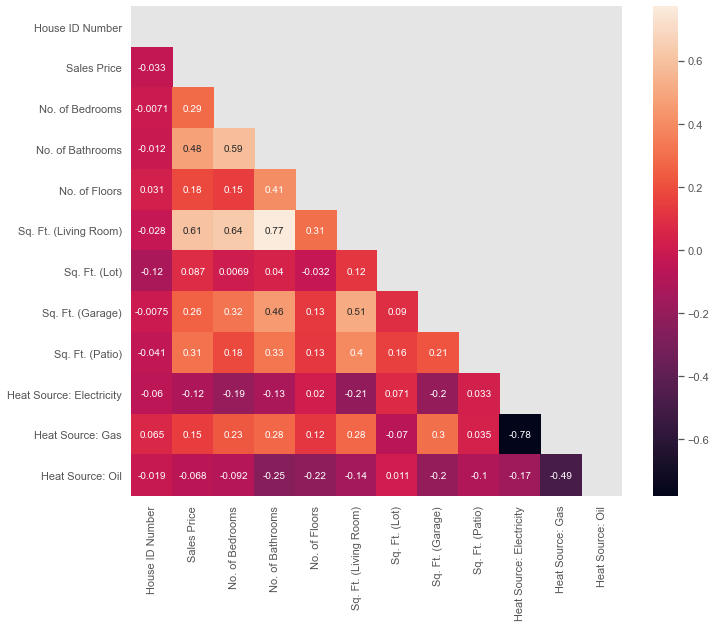

In [64]:
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(housing_df4.corr(), dtype=bool))
sns.heatmap(housing_df4.corr(), mask=mask, annot=True);

...talk about heatmap...

...find which variables violate the multicollinearity principle..

In [68]:
data_copy = housing_df4.copy()
data_copy = data_copy.corr().abs().stack().reset_index().sort_values(0, ascending=False)
data_copy['Predictor pairs'] = list(zip(data_copy['level_0'], data_copy['level_1']))
data_copy.set_index(['Predictor pairs'], inplace = True)
data_copy.drop(columns=['level_0', 'level_1'], inplace=True)
data_copy.rename(columns={0:'Correlation (r)'}, inplace=True)
data_copy.drop_duplicates(inplace=True)

In [69]:
data_copy.head(20)

,Correlation (r)
Predictor pairs,
"(House ID Number, House ID Number)",1.000000
"(Heat Source: Electricity, Heat Source: Gas)",0.777930
"(Sq. Ft. (Living Room), No. of Bathrooms)",0.771836
"(Sq. Ft. (Living Room), No. of Bedrooms)",0.637260
"(Sq. Ft. (Living Room), Sales Price)",0.607879
"(No. of Bedrooms, No. of Bathrooms)",0.587976
"(Sq. Ft. (Living Room), Sq. Ft. (Garage))",0.511847
"(Heat Source: Gas, Heat Source: Oil)",0.485378
"(Sales Price, No. of Bathrooms)",0.479305
